In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(42)


In [2]:

data_dir = "./"
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print("列名：", header)
print("总行数：", len(lines))


列名： ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
总行数： 420551


float_data 形状： (420551, 14)


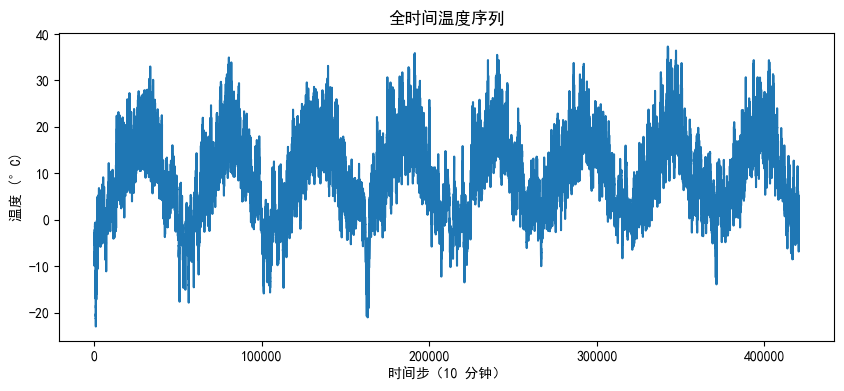

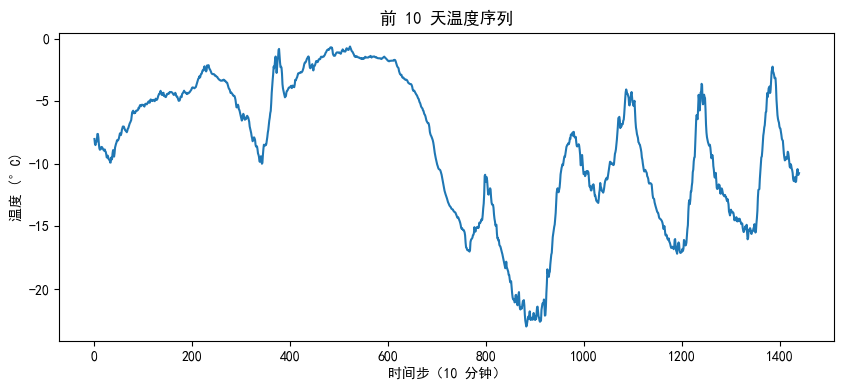

In [3]:

# 将数据转为浮点型 Numpy 数组
float_data = np.zeros((len(lines), len(header) - 1), dtype="float32")
for i, line in enumerate(lines):
    if not line.strip():
        continue
    values = [float(x) for x in line.split(",")[1:]]  # 跳过日期
    float_data[i, :] = values

print("float_data 形状：", float_data.shape)

# 画出全局温度时间序列 & 前 10 天的温度
temp = float_data[:, 1]  # 'T (degC)' 列
plt.figure(figsize=(10, 4))
plt.plot(range(len(temp)), temp)
plt.title("全时间温度序列")
plt.xlabel("时间步（10 分钟）")
plt.ylabel("温度 (°C)")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(range(1440), temp[:1440])
plt.title("前 10 天温度序列")
plt.xlabel("时间步（10 分钟）")
plt.ylabel("温度 (°C)")
plt.show()


In [4]:

# 使用前 200000 个时间步的统计量做标准化
train_size = 200000
mean = float_data[:train_size].mean(axis=0)
std = float_data[:train_size].std(axis=0)
float_data -= mean
float_data /= std

print("标准化完成。第一行数据：")
print(float_data[0])


标准化完成。第一行数据：
[ 0.8746827  -1.9313979  -1.983176   -1.8628589   1.0728259  -1.3074368
 -1.4737775  -0.7986833  -1.4763317  -1.4781768   2.123246   -0.72953314
 -0.78073466 -0.27615127]


In [5]:

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros(len(rows), dtype="float32")
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            # 目标：delay 时间步之后的温度
            targets[j] = data[row + delay][1]
        yield samples, targets


lookback = 720
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    shuffle=False,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     shuffle=False,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

print("val_steps:", val_steps)
print("test_steps:", test_steps)


val_steps: 775
test_steps: 936


In [6]:

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        # 直接使用最后一个时间点的温度作为预测
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)


# 重新创建一个验证生成器，以免上面循环消耗数据
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    shuffle=False,
                    step=step,
                    batch_size=batch_size)

naive_val_mae = evaluate_naive_method()
print("常识基线（标准化后）验证 MAE：", naive_val_mae)


常识基线（标准化后）验证 MAE： 0.2905275452921471


In [7]:

model_gru = keras.models.Sequential()
model_gru.add(
    layers.GRU(
        32,
        dropout=0.2,
        recurrent_dropout=0.2,
        input_shape=(lookback // step, float_data.shape[-1])
    )
)
model_gru.add(layers.Dense(1))

model_gru.compile(optimizer=keras.optimizers.RMSprop(),
                  loss="mae")

history_gru = model_gru.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)


Epoch 1/20


C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.3345 - val_loss: 0.2753
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.3132 - val_loss: 0.2814
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.3058 - val_loss: 0.2701
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.3014 - val_loss: 0.2664
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.2983 - val_loss: 0.2705
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.2965 - val_loss: 0.2644
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2941 - val_loss: 0.2624
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.2913 - val_loss: 0.2648
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2907 - val_loss: 0.2763
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2865 - val_loss: 0.2680
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2855 - val_loss: 0.2651
Epoch 12/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 

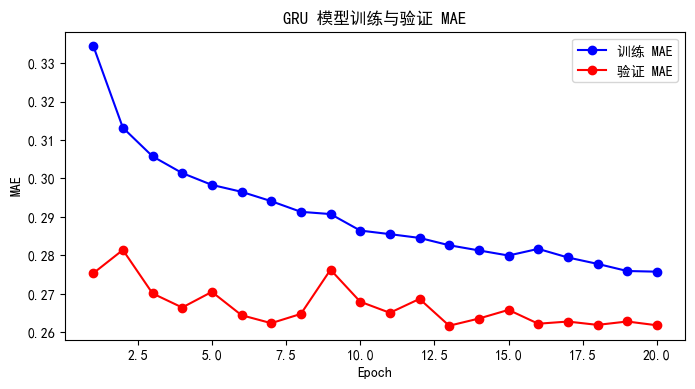

In [8]:

# 绘制 GRU 模型的训练 / 验证 MAE 曲线
loss = history_gru.history["loss"]
val_loss = history_gru.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, "bo-", label="训练 MAE")
plt.plot(epochs, val_loss, "ro-", label="验证 MAE")
plt.title("GRU 模型训练与验证 MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()


In [9]:

# 重新创建训练 / 验证生成器，避免前面迭代影响
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    shuffle=False,
                    step=step,
                    batch_size=batch_size)

model_cnn_rnn = keras.models.Sequential()
model_cnn_rnn.add(
    layers.Conv1D(
        32,
        5,
        activation="relu",
        input_shape=(None, float_data.shape[-1])
    )
)
model_cnn_rnn.add(layers.MaxPooling1D(3))
model_cnn_rnn.add(layers.Conv1D(32, 5, activation="relu"))
model_cnn_rnn.add(
    layers.GRU(
        32,
        dropout=0.1,
        recurrent_dropout=0.5
    )
)
model_cnn_rnn.add(layers.Dense(1))

model_cnn_rnn.compile(optimizer=keras.optimizers.RMSprop(),
                      loss="mae")

history_cnn_rnn = model_cnn_rnn.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)


Epoch 1/20


C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.3461 - val_loss: 0.2938
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.3124 - val_loss: 0.3107
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2990 - val_loss: 0.3052
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2911 - val_loss: 0.2901
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2826 - val_loss: 0.2963
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2764 - val_loss: 0.2988
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2678 - val_loss: 0.2953
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2637 - val_loss: 0.2938
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2590 - val_loss: 0.2875
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2530 - val_loss: 0.3084
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2509 - val_loss: 0.2948
Epoch 12/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.

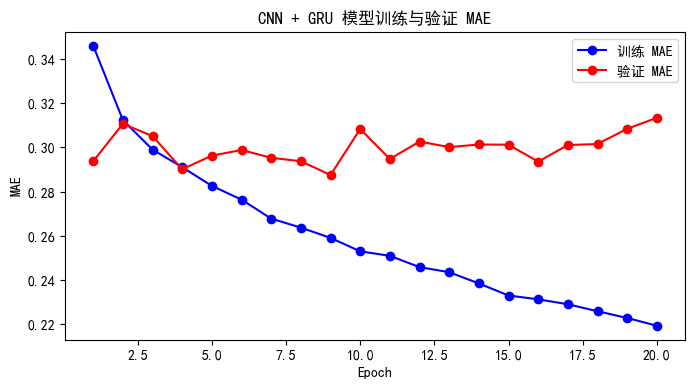

In [10]:

# 绘制 CNN+RNN 模型的训练 / 验证 MAE 曲线
loss = history_cnn_rnn.history["loss"]
val_loss = history_cnn_rnn.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, "bo-", label="训练 MAE")
plt.plot(epochs, val_loss, "ro-", label="验证 MAE")
plt.title("CNN + GRU 模型训练与验证 MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()


In [11]:

best_gru = min(history_gru.history["val_loss"])
best_cnn_rnn = min(history_cnn_rnn.history["val_loss"])

print(f"纯 GRU 模型最优验证 MAE: {best_gru:.4f}")
print(f"CNN + GRU 模型最优验证 MAE: {best_cnn_rnn:.4f}")


纯 GRU 模型最优验证 MAE: 0.2617
CNN + GRU 模型最优验证 MAE: 0.2875
